### Estimate EEG Data without Artifcats

In [1]:
%matplotlib inline

In [25]:
import mne
import numpy as np
from mne.datasets import sample
import matplotlib.pyplot as plt
import h5py

#### Load Forward Model

In [3]:
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
info = mne.io.read_info(raw_fname) 
fwd = mne.read_forward_solution("sample_forward_model")

    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
Reading forward solution from sample_forward_model...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


<ipython-input-3-4a7190ffba04>:4: RuntimeWarning: This filename (sample_forward_model) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution("sample_forward_model")


In [4]:
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                         use_cps=True)

    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]


In [5]:
leadfield = fwd_fixed['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

Leadfield size : 60 sensors x 7498 dipoles


In [9]:
n_dipoles = leadfield.shape[1]
vertices = [src_hemi['vertno'] for src_hemi in fwd_fixed['src']]
# stc = mne.SourceEstimate(1e-9 * np.eye(n_dipoles), vertices, tmin=0., tstep=1)
# leadfield = mne.apply_forward(fwd_fixed, stc, info).data / 1e-9

#### Use Forward Model to Estimate Data

In [74]:
n_sensors = 60
n_times = 36000
time_step = .5

Random source

In [75]:
z = np.dot(np.random.randn(n_dipoles, n_sensors), np.random.randn(n_sensors, n_times)) * 1e-9

In [76]:
# n_dipoles = leadfield.shape[1]
vertices = [src_hemi['vertno'] for src_hemi in fwd_fixed['src']]
# z = np.random.randn(n_dipoles, n_dipoles) * 1e-9
stc = mne.SourceEstimate(z, vertices, tmin=0., tstep=time_step)
leadfield = mne.apply_forward(fwd_fixed, stc, info).data# / np.sum(z, axis=1)

Projecting source estimate to sensor space...
[done]


In [13]:
leadfield.shape

(60, 36000)

In [77]:
leadfield = mne.apply_forward(fwd_fixed, stc, info)

Projecting source estimate to sensor space...
[done]


In [97]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

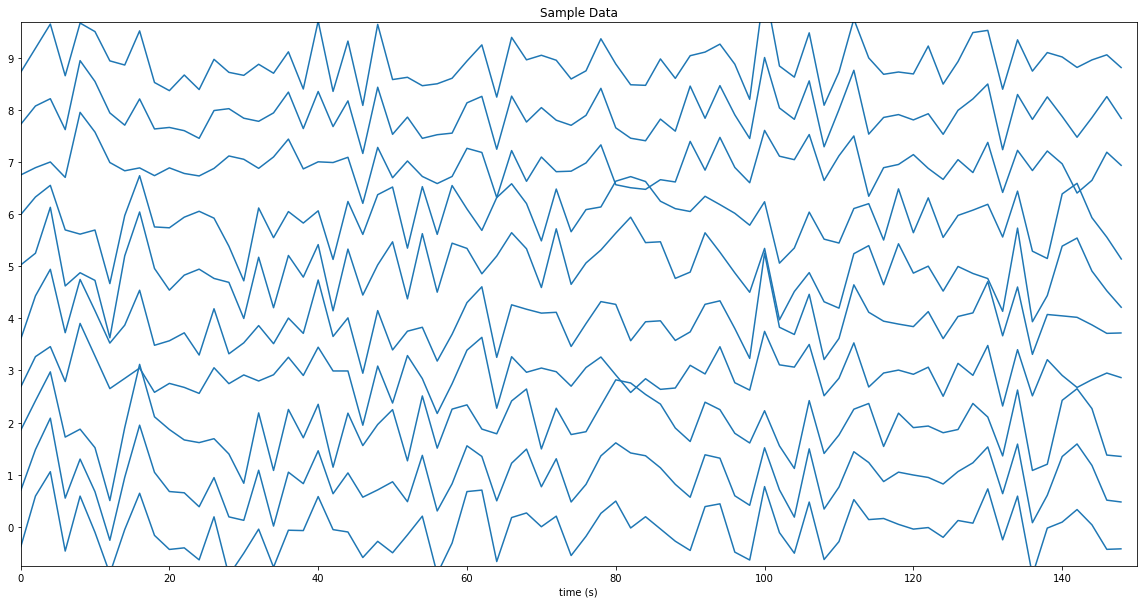

In [98]:
stacklineplot.show_epoch_centered(x, 0, epoch_width_sec=300, chstart=0, chstop=10, fs=.5, ylabels=range(60), yscale=2.0)
plt.title('Sample Data');

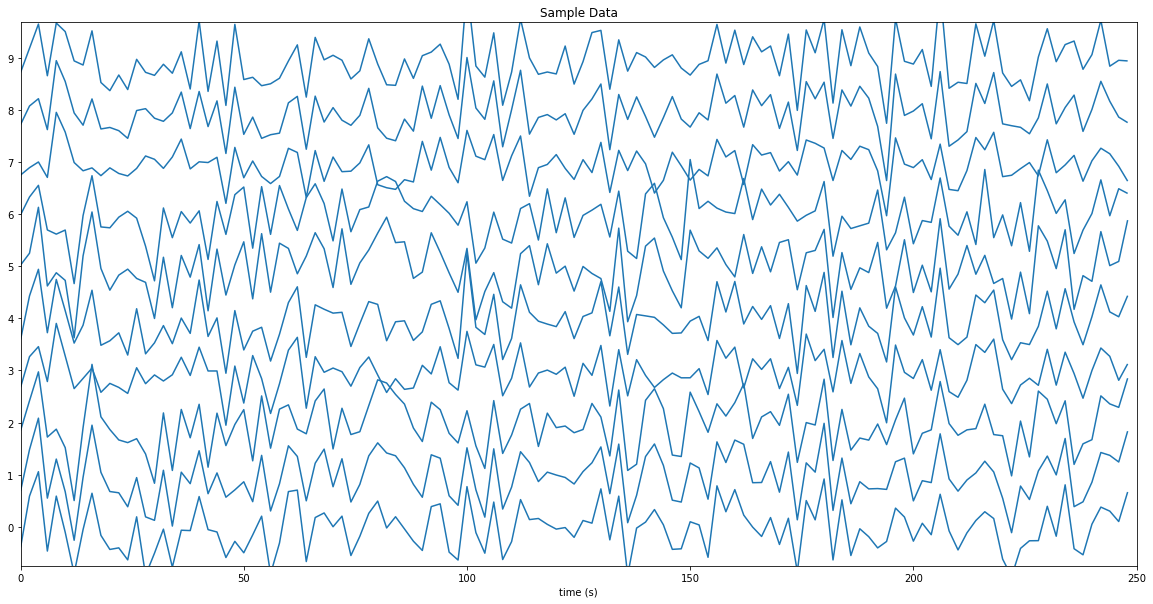

In [99]:
stacklineplot.show_epoch_centered(x, 100, epoch_width_sec=300, chstart=0, chstop=10, fs=.5, ylabels=range(60), yscale=2.0)
plt.title('Sample Data');

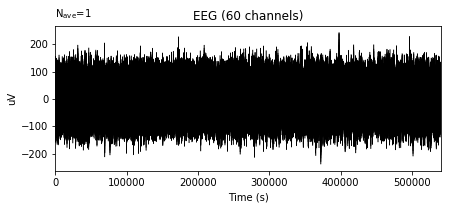

In [16]:
fig = leadfield.plot(exclude=(), time_unit='s')

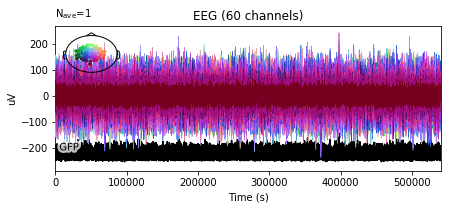

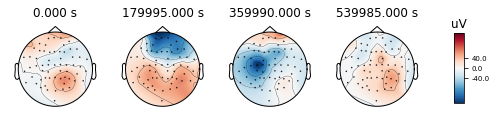

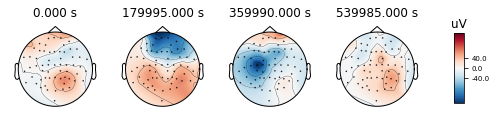

In [17]:
picks = mne.pick_types(leadfield.info, meg=False, eeg=True, eog=False)
leadfield.plot(spatial_colors=True, gfp=True, picks=picks, time_unit='s')
leadfield.plot_topomap(time_unit='s')

In [18]:
import stacklineplot 

In [32]:
leadfield.data.shape

(60, 36000)

In [47]:
x = h5py.Group()

TypeError: __init__() missing 1 required positional argument: 'bind'

In [46]:
dset =  h5py.Group.create_dataset(name="generated_data", data=leadfield.data)

TypeError: create_dataset() missing 1 required positional argument: 'self'

In [64]:
type(x)

h5py._hl.dataset.Dataset

In [66]:
x.shape

(60, 36000)

#### To save data

In [54]:
f = h5py.File('mytestfile.hdf5', 'w')

In [79]:
f.create_dataset("generated_data_b", data=leadfield.data)

<HDF5 dataset "generated_data_b": shape (60, 36000), type "<f8">

In [57]:
list(f.keys())

['generated_data']

In [80]:
x = f["generated_data_b"]

In [49]:
h5f = h5py.File('test.h5', 'w')
h5f.create_dataset('test', data=leadfield.data)
# h5f.close()
h5f = h5py.File('test.h5','r')
type(h5f['test'][:])

OSError: Unable to create file (Unable to truncate a file which is already open)